# `OptimizeWMOs` Demo for CaUWMET

~6/19/2023~ 10/11/2023

Mark Green

This section runs an optionally-constrained **P**article **S**warm **O**ptimizer algorithm on the `EconomicLoss` function for CaUWMET model to determine the distribution of longterm **W**ater **M**anagement **O**ptions of least cost.

One may need to use ipykernel `pip` to install and import libraries.... 



Instantiate optimizer for City of Coalinga...
Optimizer ready
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.8000 |  1.0E+01 |  1.00000 |  5.598736E+06 |  5.457615E+06
     2 |       40 |  0.18553 |       3 |  0.5192 |  2.50000 |  1.50000 |  5.561712E+06 |  5.457615E+06
     3 |       60 | -2.4E-02 |       3 |  0.3850 |  2.47002 |  1.54140 |  5.509495E+06 |  5.429373E+06
     4 |       80 | -4.9E-02 |       3 |  0.3696 |  2.44661 |  1.57395 |  5.482548E+06 |  5.422945E+06
     5 |      100 |  0.67042 |       1 |  0.7921 |  2.50000 |  1.50000 |  5.469155E+06 |  5.421210E+06
     6 |      120 |  0.00200 |       3 |  0.4013 |  2.47540 |  1.53394 |  5.458244E+06 |  5.421210E+06
     7 |      140 | -2.2E-03 |       3 |  0.3986 |  2.45344 |  1.56442 |  5.446696E+06 |  5.421210E+06
     8 |      160 | -2.7E-02 |       3 |  0.3831 |  2.43630 |  1.58148 |  5.442997E+06 |  5.421210E+06
     9 |  

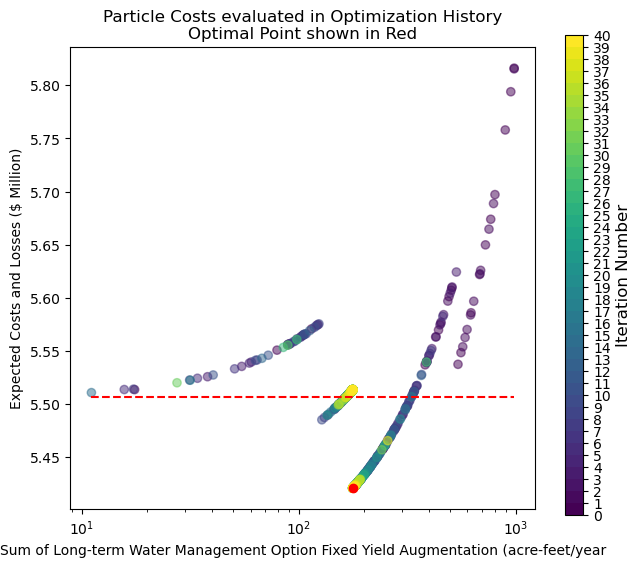

In [1]:
from datetime import timedelta

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from src.optimization.optimizeWMOs import OptimizeWMOs
from src.optimization.getResults import GetResults

filenames = [
    'ModelOutputs_Optimal.xlsx',
    'QAQCResults_Optimal.xlsx'
]
verbose = True
contractor = 'City of Coalinga'
wmoFloor=None
wmoCeiling=None
lowerBounds=[0]*8
upperBounds='longtermWMOVolumeLimits'

print(f"\nInstantiate optimizer for {contractor}...")

modelLogic = ModelLogic(InputData(InputDataLocations()),StorageUtilities())
optimizeWMOs = OptimizeWMOs(
    verbose=verbose,
    modelLogic=modelLogic,
    contractor=contractor,
    wmoFloor=wmoFloor,
    wmoCeiling=wmoCeiling,
    lowerBounds=lowerBounds,
    upperBounds=upperBounds,
    zero_threshold=1,
    n_gen=100,
    pop_size=20
)
print('Optimizer ready')

result = optimizeWMOs.optimize(result=True)
X_optim, F_optim = optimizeWMOs.reportBest()
exec_time = timedelta(seconds = round(result.exec_time))
print("Model optimized")

modelOutputsOptimAll = GetResults(modelLogic=modelLogic)
qaqcResultsOptimAll = GetResults(modelLogic=modelLogic)
modelOutputsOptim, qaqcResultsOptim = optimizeWMOs.exportResults()
modelOutputsOptimAll.appendResults(modelOutputsOptim)
qaqcResultsOptimAll.appendResults(qaqcResultsOptim)

X_zero, F_zero = optimizeWMOs.reportZero()

modelOutputsZeroAll = GetResults(modelLogic=modelLogic)
qaqcResultsZeroAll = GetResults(modelLogic=modelLogic)
modelOutputsZero, qaqcResultsZero = optimizeWMOs.exportResults()
modelOutputsZeroAll.appendResults(modelOutputsZero)
qaqcResultsZeroAll.appendResults(qaqcResultsZero)
print("Results ready for export")

optimizeWMOs.visualization_a(save=False)


In [5]:
contractor = 'City of Folsom'

print(f"\nInstantiate optimizer for {contractor}...")

modelLogic = ModelLogic(InputData(InputDataLocations()),StorageUtilities())
optimizeWMOs = OptimizeWMOs(
    verbose=verbose,
    modelLogic=modelLogic,
    contractor=contractor,
    wmoFloor=wmoFloor,
    wmoCeiling=wmoCeiling,
    lowerBounds=lowerBounds,
    upperBounds=upperBounds,
    zero_threshold=1,
    n_gen=20,
    pop_size=20
)
print('Optimizer ready')

result = optimizeWMOs.optimize(result=True)
X_optim, F_optim = optimizeWMOs.reportBest()
exec_time = timedelta(seconds = round(result.exec_time))
print("Model optimized")

# modelOutputsOptimAll = GetResults(modelLogic=modelLogic)
# qaqcResultsOptimAll = GetResults(modelLogic=modelLogic)
modelOutputsOptim, qaqcResultsOptim = optimizeWMOs.exportResults()


Instantiate optimizer for City of Folsom...
Optimizer ready
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.8000 |  1.0E+01 |  1.00000 |  1.668178E+07 |  1.473156E+07
     2 |       40 |  0.25748 |       2 |  0.5656 |  2.50000 |  1.50000 |  1.624118E+07 |  1.473156E+07
     3 |       60 | -7.4E-03 |       3 |  0.3954 |  2.46971 |  1.54182 |  1.547162E+07 |  1.473156E+07
     4 |       80 | -3.6E-02 |       3 |  0.3779 |  2.44440 |  1.57704 |  1.498539E+07 |  1.464851E+07
     5 |      100 |  0.02503 |       3 |  0.4157 |  2.42114 |  1.60699 |  1.476333E+07 |  1.463649E+07
     6 |      120 | -2.9E-02 |       3 |  0.3818 |  2.39813 |  1.62324 |  1.467962E+07 |  1.463649E+07
     7 |      140 | -4.9E-02 |       3 |  0.3698 |  2.37799 |  1.64589 |  1.464742E+07 |  1.463649E+07
     8 |      160 | -3.5E-02 |       3 |  0.3783 |  2.35761 |  1.66501 |  1.464279E+07 |  1.463649E+07
     9 |    

In [6]:
modelOutputsOptimAll.appendResults(modelOutputsOptim)
modelOutputsOptimAll.writeResults(filenames[0])
#qaqcResultsOptimAll.writeResults(filenames[1])
#print("Results exported")

In [2]:
from bokeh.plotting import figure, show, save, output_file
from bokeh.models import ColumnDataSource, ColorBar, HoverTool, Label, CustomJS
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.io import output_notebook

import numpy as np

# parse the results output to columns
X = []
F = []
colors = []
c = 0
try:
    for h in result.history:
        for p in h.particles:
            if wmoCeiling is not None:
                if np.sum(p._X) < wmoCeiling:
                    X.append(p._X)
                    F.append(p._F)
                    colors.append(c)
            else: 
                X.append(p._X)
                F.append(p._F)
                colors.append(c)
        c+=1
except: 
    print("Couldn't get particles. Aborting...")

TAF = np.sum(X,axis=1)  # sum of longtermWMOSupply variables

ltwmolist = [list(arr) for arr in zip(*X)]

# data dict for plot
data = {
    'x': TAF,
    'y': [ f[0] for f in F ],
    'colors': colors, 
    'conservation':	[ round(l,1) for l in ltwmolist[0] ],
    'surface': [ round(l,1) for l in ltwmolist[1] ],
    'groundwater': [ round(l,1) for l in ltwmolist[2] ],
    'desalination': [ round(l,1) for l in ltwmolist[3] ],
    'recycled': [ round(l,1) for l in ltwmolist[4] ],
    'potable_reuse': [ round(l,1) for l in ltwmolist[5] ],
    'transfers_exchanges': [ round(l,1) for l in ltwmolist[6] ],
    'other': [ round(l,1) for l in ltwmolist[7] ]
}

# https://github.com/bokeh/bokeh/issues/9087
TOOLTIPS = """
<div>
  Conservation: @conservation <br>
  Surfacewater: @surface <br>
  Groundwater: @groundwater <br>
  Desalination: @desalination <br>
  Recycled: @recycled <br>
  Potable Reuse: @potable_reuse <br>
  Transfers and Exchanges: @transfers_exchanges <br>
  Other Sources: @other
</div>
<style>
  div.bk-tooltip-content > div > div:not(:first-child) {
    display:none !important;
  } 
</style>
"""

source = ColumnDataSource(data=data)

mapper = linear_cmap(field_name='colors', palette=Viridis256, low=min(data['colors']), high=max(data['colors']))

p = figure(tools="pan,zoom_in,zoom_out,box_zoom,reset,save", toolbar_location="below", toolbar_sticky=False,
           x_axis_type='log', y_axis_type='log')

scatter = p.scatter(x='x', y='y', size=10, source=source, 
                    fill_color=mapper, line_color='black', line_width=0.5)

scatter2 = p.scatter(x=data['x'][-1], y=data['y'][-1], size=11,
                     fill_color='red', line_color='black', line_width=0.5)

label = Label(x=data['x'][-1], y=data['y'][-1], 
              text="Optimized", text_font_size="12pt", 
              x_offset=-15, y_offset=-20)
p.add_layout(label)

hover = HoverTool(renderers=[scatter], tooltips=TOOLTIPS)
p.add_tools(hover)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
p.add_layout(color_bar, 'right')

output_notebook()

Loading BokehJS ...

In [3]:
# output_file("C:\\Users\\< user id >\\Downloads\\test.html")
# save(p)
show(p)

# Below here is old! 

### Example with No Constraints

In [1]:
from src.optimization.optimizeWMOs import OptimizeWMOs

# parameterize the optimization - class defaults below...
year='2045'
contractor='Metropolitan Water District of Southern California'
wmoFloor=None
wmoCeiling=None
lowerBounds=[0]*8
upperBounds='longtermWMOVolumeLimits'

print("Instantiate default Optimize class")
optimizeWMOs = OptimizeWMOs(
    year=year,
    contractor=contractor,
    wmoFloor=wmoFloor,
    wmoCeiling=wmoCeiling,
    lowerBounds=lowerBounds,
    upperBounds=upperBounds
)

print("Optimize with default settings:")
res1 = optimizeWMOs.optimize()

print("Visualized results:")
optimizeWMOs.visualization_a(save=True)

Instantiate default Optimize class


TypeError: OptimizeWMOs.__init__() got an unexpected keyword argument 'year'

### Example with Floor Constraint on `longtermWMOs`

Instantiate default Optimize class
Optimize with default settings:
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.8000 |  1.0E+01 |  1.00000 |  0.000000E+00 |  0.000000E+00 |  2.179011E+09 |  1.456448E+09
     2 |       40 |  0.53879 |       1 |  0.7302 |  2.50000 |  1.50000 |  0.000000E+00 |  0.000000E+00 |  2.067939E+09 |  1.456448E+09
     3 |       60 |  0.22375 |       3 |  0.5440 |  2.47262 |  1.53779 |  0.000000E+00 |  0.000000E+00 |  1.732215E+09 |  1.422320E+09
     4 |       80 | -7.3E-02 |       3 |  0.3556 |  2.45453 |  1.56291 |  0.000000E+00 |  0.000000E+00 |  1.421348E+09 |  1.237696E+09
     5 |      100 |  0.04613 |       3 |  0.4291 |  2.43781 |  1.57945 |  0.000000E+00 |  0.000000E+00 |  1.286973E+09 |  1.180016E+09
     6 |      120 | -4.8E-02 |       3 |  0.3702 |  2.41874 |  1.60485 |  0.000000E+00 |  0.000000E+00 |  1.218234E+09 |  1

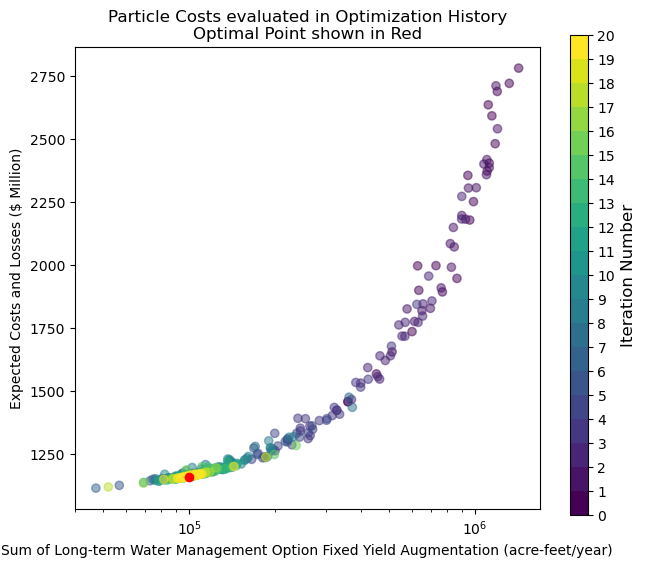

<Figure size 640x480 with 0 Axes>

In [3]:
from src.optimization.optimizeWMOs import OptimizeWMOs

# parameterize the optimization - class defaults below...
year='2045'
contractor='Metropolitan Water District of Southern California'
wmoFloor=10**5
wmoCeiling=None
lowerBounds=[0]*8
upperBounds='longtermWMOVolumeLimits'

print("Instantiate default Optimize class")
optimizeWMOs = OptimizeWMOs(
    year=year,
    contractor=contractor,
    wmoFloor=wmoFloor,
    wmoCeiling=wmoCeiling,
    lowerBounds=lowerBounds,
    upperBounds=upperBounds
)

print("Optimize with default settings:")
res2 = optimizeWMOs.optimize()

print("Visualized results:")
optimizeWMOs.visualization_a(save=True)

### Example with Floor and Ceiling Constraints on `longtermWMOs`

Instantiate default Optimize class
Optimize with default settings:
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.8000 |  1.0E+01 |  1.00000 |  1.812850E+05 |  7.233690E+05 |             - |             -
     2 |       40 |  0.54441 |       1 |  0.7330 |  2.50000 |  1.50000 |  1.812850E+05 |  6.459065E+05 |             - |             -
     3 |       60 |  0.12492 |       3 |  0.4798 |  2.47081 |  1.54029 |  1.812850E+05 |  4.055244E+05 |             - |             -
     4 |       80 | -3.4E-02 |       3 |  0.3791 |  2.45762 |  1.55811 |  2.159186E+04 |  1.697332E+05 |             - |             -
     5 |      100 |  0.04791 |       3 |  0.4302 |  2.43914 |  1.58364 |  0.000000E+00 |  3.445443E+04 |  1.209627E+09 |  1.167698E+09
     6 |      120 | -1.9E-02 |       3 |  0.3880 |  2.41691 |  1.60770 |  0.000000E+00 |  5.150994E+03 |  1.199382E+09 |  1

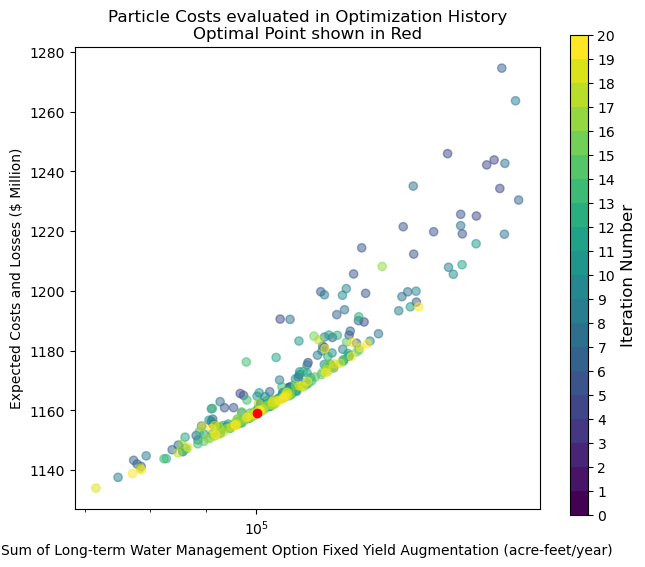

<Figure size 640x480 with 0 Axes>

In [4]:
from src.optimization.optimizeWMOs import OptimizeWMOs

# parameterize the optimization - class defaults below...
year='2045'
contractor='Metropolitan Water District of Southern California'
wmoFloor=10**5
wmoCeiling=10**5.25
lowerBounds=[0]*8
upperBounds='longtermWMOVolumeLimits'

print("Instantiate default Optimize class")
optimizeWMOs = OptimizeWMOs(
    year=year,
    contractor=contractor,
    wmoFloor=wmoFloor,
    wmoCeiling=wmoCeiling,
    lowerBounds=lowerBounds,
    upperBounds=upperBounds
)

print("Optimize with default settings:")
res3 = optimizeWMOs.optimize()

print("Visualized results:")
optimizeWMOs.visualization_a(save=True)

In [5]:
res3.__dict__

{'opt': Population([<pymoo.core.individual.Individual object at 0x7f9d757c5c60>],
            dtype=object),
 'success': None,
 'message': None,
 'problem': <src.optimization.optimizeWMOs.CostProblem at 0x7f9d779f5090>,
 'archive': None,
 'pf': None,
 'algorithm': <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9d77cdaef0>,
 'pop': Population([<pymoo.core.individual.Individual object at 0x7f9d7fde8700>,
            dtype=object),
 'X': array([8.70921650e-05, 3.87337420e-06, 6.24126748e+02, 1.68799465e+04,
        1.91730015e+04, 6.29893316e+04, 3.82329152e+02, 3.98145265e-05]),
 'F': array([1.15900445e+09]),
 'CV': array([0.]),
 'G': array([-4.87357064e+01, -7.77792053e+04]),
 'H': array([], dtype=float64),
 'start_time': 1689265757.7504177,
 'end_time': 1689265866.0789845,
 'exec_time': 108.32856678962708,
 'history': [<pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9d77cdbc40>,
  <pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f9d7570f9d0>]}

# Development Section

**Warning!**

Code in here may be out of date. Always refer to the `src/optimize/optimizeWMOs.py` file for the most up-to-date optimization code. 

In [3]:
!pip install numpy matplotlib pymoo

from IPython.core.debugger import set_trace  # use set_trace to engage ipy debugger like pdb

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import warnings

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

warnings.filterwarnings('ignore')  # turn off warnings

## `CostProblem` Class

Defines the `CostProblem` - a `pymoo` problem class for the CaUWMET model. This problem class defines for an optimization algorithm the search space (function response surface topology), boundary conditions $G$ associated with both the response surface $F$, and the limits $X_l$ and $X_u$ of dimensions $X$ (longtermWMOs). 

In [7]:
### PyMoo Optimization Problem Class ###

class CostProblem(ElementwiseProblem): 
    '''
    This class is a PyMoo problem class designed to simulate the effects of longtermWMOSupply levels...
    ...on water usage cost optimization (economicLoss) for a given contractor. 
    The objective space of F(X) is mapped by an algorithm, within the u/l bounds for each dimension of X.
    Optionally, F(X) can be constrained by inequality constraints G(X): 
       + g1(x) > wmoFloor  :: defines a floor value of the sum( longtermWMOSupply ) 
       + g2(x) < wmoSupply :: defines a ceiling value of the sum( longtermWMOSupply )
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each longtermWMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each longtermWMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 wmoFloor=None,              # how low are we constraining the sum longtermWMOs?
                 wmoSupply=None,             # how high are we constraining the sum longtermWMOs?
                 **kwargs):    
        '''
        Initializing the CostProblem class requires parameterizing a CaUWMET model for a given contractor.
        Inputs:
            wmoFloor/wmoSupply :: number > 0, max sum of the longtermWMO allocations
            lowerBounds/upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoFloor = wmoFloor if wmoFloor is not None else None
        self.wmoSupply = wmoSupply if wmoSupply is not None else None
        self.n_ieq_constr = sum([i != None for i in [self.wmoFloor, self.wmoSupply]])
        self.lowerBounds = lowerBounds
        self.upperBounds = [ ub if ub>0 else 0.01 for ub in upperBounds ]
        self.objectiveFunction = modelLogic.execute  # execute ModelLogic
        
        super().__init__(  # parameterize the objective function
            n_var=8, n_obj=1, n_ieq_constr=self.n_ieq_constr, 
            xl=self.lowerBounds, xu=self.upperBounds,  # xl and xu set longtermWMOSupply bounds 
            **kwargs
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x)
        Returns inequality constraints g(x)
        '''
        tic = time.perf_counter()
        if self.n_ieq_constr > 0:
            out["F"] = self.objectiveFunction(x)
            G1 = self.wmoFloor - np.sum(x)   # np.sum(x) >= self.wmoFloor
            G2 = np.sum(x) - self.wmoSupply  # self.wmoSupply >= np.sum(x)
            out["G"] = [G1, G2]
        else:
            out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        

## `OptimizeWMOs` Class

The `OptimizeWMOs` creates an object parameterized by the target year and contractor for which a `CostProblem` is to be run. The `optimize` method runs a metaheuristic optimization algorithm (using the [PyMoo](https://pymoo.org/algorithms/soo/pso.html) framework) on the defined CaUWMET model cost problem. The results of the optimization are stored and can be output using a `visualization_*` method. 

In [8]:
class OptimizeWMOs:
    '''
    This class parameterizes, executes, and reports the optimization results of the CostProblem() class.
    Parameterizing the contractor prepares a ModelLogic object, and the year sets the longtermWMO Volumelimits (upper bounds).
    The other inputs are used to execute the PyMoo optimization. Results are stored and accessed for visualization methods. 
    TODO: Need to handle class inheritance better
    '''
    def __init__(self, 
                 year='2045', 
                 contractor='Metropolitan Water District of Southern California',
                 wmoFloor=None, 
                 wmoSupply=None, 
                 lowerBounds=[0]*8, 
                 upperBounds='longtermWMOVolumeLimits'):
        
        self.inputData = InputData(InputDataLocations())
        self.modelLogic = ModelLogic(self.inputData, StorageUtilities())
        self.modelLogic.contractor = contractor
        self.wmoFloor = wmoFloor
        self.wmoSupply = wmoSupply
        self.lowerBounds = lowerBounds
        self.upperBounds = upperBounds if upperBounds != 'longtermWMOVolumeLimits' else [
            self.inputData.longtermWMOSurfaceVolumeLimit[self.inputData.longtermWMOSurfaceVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMOGroundwaterVolumeLimit[self.inputData.longtermWMOGroundwaterVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMODesalinationVolumeLimit[self.inputData.longtermWMODesalinationVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMORecycledVolumeLimit[self.inputData.longtermWMORecycledVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMOPotableReuseVolumeLimit[self.inputData.longtermWMOPotableReuseVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMOTransfersExchangesVolumeLimit[self.inputData.longtermWMOTransfersExchangesVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMOOtherSupplyVolumeLimit[self.inputData.longtermWMOOtherSupplyVolumeLimit.index==contractor][year][0],
            self.inputData.longtermWMOConservationVolumeLimit[self.inputData.longtermWMOConservationVolumeLimit.index==contractor][year][0],
        ]
        
    
    def optimize(self):
        '''
        This method parameterizes the CostProblem and executes the PyMoo optimization. 
        The optimization algorithm and termination criteria are hardcoded for now...
        '''
        # parameterize the problem
        problem = CostProblem(
            modelLogic=self.modelLogic,
            wmoFloor=self.wmoFloor, wmoSupply=self.wmoSupply, 
            lowerBounds=self.lowerBounds, upperBounds=self.upperBounds
        )
        # parameterize algorithm
        algorithm = PSO(
            pop_size=20,
            w=0.8, c1=10.0, c2=1.0,
            adaptive=True,
            max_velocity_rate=0.5
        )
        # parameterize the termination criteria
        termination = get_termination("n_gen", 20)
        
        # execute optimization
        self.res = minimize(
            problem, 
            algorithm, 
            termination, 
            seed=42, 
            verbose=True,
            save_history=True
        )

        print("Best solution found: \nX = %s\nF = %s" % (self.res.X, self.res.F))
        
        return self.res
        
        
    def visualization_a(self):
        '''
        This method can be called after the self.res object has been created by the optimize() method. 
        Accessing the optimization history in self.res allows for plotting of the optimization search results.
        
        '''
        # get the particles - this should be its own self callable method...
        X = []
        F = []
        try:
            for h in self.res.history:
                for p in h.particles:
                    X.append(p._X)
                    F.append(p._F)
        except: 
            print("Couldn't get particles. Aborting...")
        
        # assign plot variables
        TAF = np.sum(X,axis=1)  # sum of longtermWMOSupply variables
        loss_millions = [f*10**-6 for f in F]
        colors = [ item for item in list(range(len(self.res.history))) for i in range(len(self.res.pop)) ]  # this only works for the n_gen=5 because of this....

        # matplotlib
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))          # setup the plot
        cmap = plt.cm.viridis                                 # define the colormap
        cmaplist = [cmap(i) for i in range(cmap.N)]           # extract all colors from map
        cmap = mpl.colors.LinearSegmentedColormap.from_list(  # create the new map
            'Custom cmap', cmaplist, cmap.N
        )
        bounds = np.linspace(0, len(self.res.history), len(self.res.history)+1)   # define the bins
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)        # normalize

        ax.scatter(TAF, loss_millions, c=colors, cmap=cmap, norm=norm, alpha=0.5)
        ax.set_title("Particle Costs evaluated in Optimization History\nOptimal Point shown in Red")
        ax.set_xlabel("Sum of Long-term Water Management Option Fixed Yield Augmentation (acre-feet/year)")
        ax.set_xscale('log')
        ax.set_ylabel("Expected Costs and Losses ($ Million)")
        ax.ticklabel_format(axis="y", style="sci", useOffset=False)

        # create a second axes for the colorbar
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        cb = mpl.colorbar.ColorbarBase(
            ax2, cmap=cmap, norm=norm,
            spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i'
        )
        ax2.set_ylabel('Iteration Number', size=12)

        # plot the best result in red
        ax.scatter(x=sum(self.res.X), y=self.res.F*10**-6, c='red')
        
        return ax



## Run the model

This section runs the model. Feel free to play with some of the inputs

Instantiate default Optimize class
Optimize with default settings:
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.8000 |  1.0E+01 |  1.00000 |  1.873249E+09 |  1.461049E+09
     2 |       40 |  0.30201 |       2 |  0.5938 |  2.50000 |  1.50000 |  1.809783E+09 |  1.461049E+09
     3 |       60 | -8.9E-02 |       3 |  0.3457 |  2.48028 |  1.52719 |  1.623507E+09 |  1.400168E+09
     4 |       80 |  0.24201 |       2 |  0.5557 |  2.50000 |  1.50000 |  1.393315E+09 |  1.254278E+09
     5 |      100 | -2.8E-02 |       3 |  0.3824 |  2.47589 |  1.53326 |  1.248057E+09 |  1.141088E+09
     6 |      120 |  0.00044 |       3 |  0.4003 |  2.45413 |  1.56347 |  1.154990E+09 |  1.083380E+09
     7 |      140 |  0.31792 |       2 |  0.6038 |  2.49075 |  1.51274 |  1.115427E+09 |  1.078412E+09
     8 |      160 | -2.6E-02 |       3 |  0.3838 |  2.46967 |  1.54187 |  1.089862E+09 |  1.071610E+09
     9

<Axes: title={'center': 'Particle Costs evaluated in Optimization History\nOptimal Point shown in Red'}, xlabel='Sum of Long-term Water Management Option Fixed Yield Augmentation (acre-feet/year)', ylabel='Expected Costs and Losses ($ Million)'>

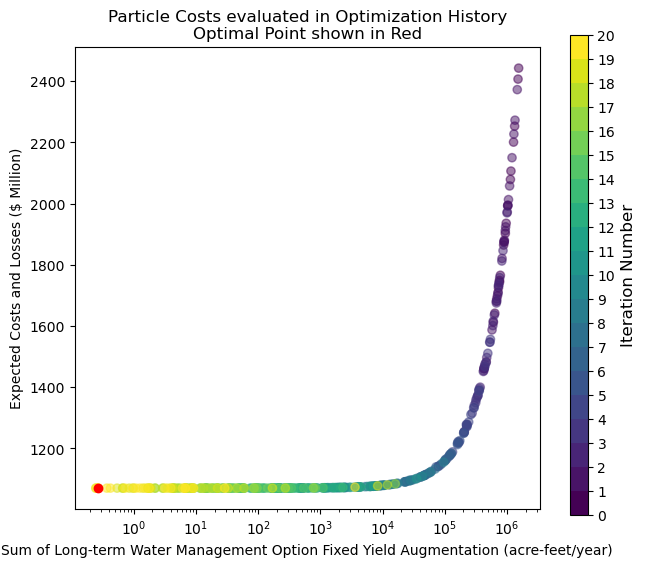

In [9]:
%%time

print("Instantiate default Optimize class")
Test = OptimizeWMOs()

print("Optimize with default settings:")
res = Test.optimize()
# res.__dict__ # for exploring

print("Visualized results:")
Test.visualization_a()

In [15]:
res.algorithm.__dict__

{'problem': <__main__.CostProblem at 0x7f0a477ab850>,
 'termination': <pymoo.termination.max_gen.MaximumGenerationTermination at 0x7f0a4c254f10>,
 'output': <pymoo.algorithms.soo.nonconvex.pso.PSOFuzzyOutput at 0x7f0a4c254340>,
 'archive': None,
 'display': <pymoo.util.display.display.Display at 0x7f0a4c3efc10>,
 'callback': <pymoo.core.callback.Callback at 0x7f0a4c254310>,
 'return_least_infeasible': False,
 'save_history': True,
 'verbose': True,
 'seed': 42,
 'evaluator': <pymoo.core.evaluator.Evaluator at 0x7f0a4c254220>,
 'history': [<pymoo.algorithms.soo.nonconvex.pso.PSO at 0x7f0a4c255060>,
 'pop': Population([<pymoo.core.individual.Individual object at 0x7f0a4729ed10>,
            dtype=object),
 'off': Population([<pymoo.core.individual.Individual object at 0x7f0a4729ed10>,
            dtype=object),
 'opt': Population([<pymoo.core.individual.Individual object at 0x7f0a47199480>],
            dtype=object),
 'n_iter': 21,
 'data': {},
 'is_initialized': True,
 'start_time': 16

### Parallelization Test (under development)

simple PSO optimization

No constraints, attempt to parallelize with `multiprocessing` 

https://docs.python.org/3/library/multiprocessing.html?highlight=multiprocessing#multiprocessing.pool.Pool.starmap

In [ ]:
### Attempt to Parallelize ###

from IPython.core.debugger import set_trace

import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

upperBounds = [
    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0]
]
lowerBounds = [0]*8

# initialize the thread pool and create the runner for parallelizaiton via Starmap
n_threads = 4
pool = ThreadPool(n_threads)

### PyMoo Optimization Problem ###

class CostOptimizer(ElementwiseProblem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 lowerBounds: list,          # lower bound of each WMO type for a given scenario - len(list)=8
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            upperBounds/lowerBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.lowerBounds = lowerBounds       # list length 8 lower bounding WMOs
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.executeModelLogicForContractor  # modelLogic.execute
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=self.lowerBounds, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, X, out, *args, **kwargs):
        tic = time.perf_counter()
        
        # prepare the parameters for the pool
        params = [[X[k]] for k in range(len(X))]

        # calculate the function values in a parallelized manner and wait until done
        F = pool.starmap(self.objectiveFunction, params)
        
        # store the function values and return them.
        out["F"] = np.array(F)
        
        toc = time.perf_counter()


# parameterize the problem
problem = CostOptimizer(
    lowerBounds=lowerBounds, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen",5)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=True
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print('Threads:', res.exec_time)

pool.close()

### Constraint Handling Test (Under Development)

simple PSO optimization

no parallelization, attempt to constrain to WMOsupply

https://pymoo.org/constraints/index.html

In [ ]:
from IPython.core.debugger import set_trace

import time
import numpy as np
#from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

#from tests.test_modelLogic.py import ModelLogic
#from tests.test_inputDataLocationsForTesting import InputDataLocationsForTesting
#from tests.test_storageOperations import StorageUtilities

from src.modelLogic.modelLogic import ModelLogic
from src.modelLogic.inputData import InputData
from src.modelLogic.storageUtilities import StorageUtilities
from src.modelLogic.inputDataLocations import InputDataLocations

from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.termination import get_termination
from pymoo.optimize import minimize

### PyMoo Optimization Problem ###

class CostOptimizer(Problem): #Problem):
    '''
    This class is a PyMoo problem class designed to simulate the effects of wmoSupply level...
    ...on water usage cost optimization across various sources.
    
    The objective function f(x) has an equality constraint g(x) = wmoSupply.
    The algorithm is a particle swarm optimizer with default settings. 
    
    https://pymoo.org/
    '''
    def __init__(self, 
                 wmoSupply: int,             # how much are we allocating to the longterm WMOs? int for now...
                 upperBounds: list,          # upper bound of each WMO type for a given scenario - len(list)=8
                 modelLogic: ModelLogic,     # prepared ModelLogic object with InputData and StorageUtilities
                 **kwargs):    
        '''
        Initializing the CostOptimizer class requires parameterizing a given CaUWMET model
        for a given contractor and requested wmoSupply.
        Inputs:
            wmoSupply :: integer (for now..., could later be a number)
            upperBounds :: list of numbers, length 8
            modelLogic :: ModelLogic object loaded with InputData, StorageUtilities, and Contractor
        '''
        self.wmoSupply = wmoSupply           # must be greater than 0
        self.upperBounds = upperBounds       # list length 8 upper bounding WMOs
        self.objectiveFunction = modelLogic.execute # modelLogic.executeModelLogicForContractor
        
        # parameterize the objective function
        super().__init__(
            **kwargs, n_var=8, n_obj=1, #n_eq_constr=1, 
            xl=[0]*8, xu=self.upperBounds    # xl and xu set f bounds 
        )


    def _evaluate(self, x, out, *args, **kwargs):
        '''
        Inputs:
           x :: list of numbers, length 8
        Returns objective function f(x) as execution of model logic
        Returns equality constraint h(x) as wmoSupply - sum(x) = 0
        ''' 
        tic = time.perf_counter()
        out["F"] = self.objectiveFunction(x)
        toc = time.perf_counter()
        
        #print("-------+----------+")
        #print(f"Time: {toc-tic:.2f} s")
        #print("-------+----------+")
#        print(f"{(self.wmoSupply - np.sum(x,axis=1)).shape}")
#        print(f"{self.wmoSupply - np.sum(x,axis=1)}")
        #out["H"] = self.wmoSupply - np.sum(x, axis=1)

# instantiate CaUWMET model and variables
inputData = InputData(InputDataLocations())
modelLogic = ModelLogic(inputData, StorageUtilities())
modelLogic.contractor = 'Metropolitan Water District of Southern California'

year = '2045'

#upperBounds = [
#    inputData.longtermWMOSurfaceVolumeLimit[inputData.longtermWMOSurfaceVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOGroundwaterVolumeLimit[inputData.longtermWMOGroundwaterVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMODesalinationVolumeLimit[inputData.longtermWMODesalinationVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMORecycledVolumeLimit[inputData.longtermWMORecycledVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOPotableReuseVolumeLimit[inputData.longtermWMOPotableReuseVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOTransfersExchangesVolumeLimit[inputData.longtermWMOTransfersExchangesVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOOtherSupplyVolumeLimit[inputData.longtermWMOOtherSupplyVolumeLimit.index==modelLogic.contractor][year][0],
#    inputData.longtermWMOConservationVolumeLimit[inputData.longtermWMOConservationVolumeLimit.index==modelLogic.contractor][year][0],
#]

upperBounds = [50]*8
wmoSupply = 500

# parameterize the problem
problem = CostOptimizer(
    wmoSupply=wmoSupply, upperBounds=upperBounds, modelLogic=modelLogic
)

# parameterize algorithm
algorithm = PSO(
    pop_size=10,
    w=0.9, c1=5.0, c2=1.0,
    adaptive=True,
    max_velocity_rate=0.2
)

# parameterize the termination criteria
termination = get_termination("n_gen", 10)

# execute optimization
res = minimize(
    problem, 
    algorithm, 
    termination, 
    seed=42, 
    verbose=True,
    save_history=False
)
    
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
